In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

In [73]:
#load sets
kanto_df = pd.read_csv("Kanto.csv")
johto_df = pd.read_csv("Johto.csv")
hoenn_df = pd.read_csv("Hoenn.csv")

#combine datasets
pokemon_df = pd.concat([kanto_df, johto_df, hoenn_df], ignore_index=True)

In [74]:
print("Shape:", pokemon_df.shape)
print("Missing Values:", pokemon_df.isnull().sum())
print("Target Distribution (Is Legendary):", pokemon_df["Is Legendary"].value_counts())

Shape: (386, 25)
Missing Values: ID                      135
Name                      0
Generation                0
Region                    0
Type 1                    0
Type 2                  204
Base HP                   0
Base Attack               0
Base Defense              0
Base Special Attack       0
Base Special Defense      0
Base Speed                0
Total Base Stats          0
Height (m)                0
Weight (kg)               0
Capture Rate              0
Is Legendary              0
Evolution Stage           0
Hidden Ability            8
Gender Ratio              0
Catch Method              1
Base Friendship           1
Color                     1
Shape                     1
Number                  251
dtype: int64
Target Distribution (Is Legendary): Is Legendary
False    365
True      21
Name: count, dtype: int64


# Preprocessing

In [75]:
drop_cols = ['ID', 'Name', 'Type 1', 'Type 2', 'Generation', 'Capture Rate', 'Catch Method', 'Number', 'Total Base Stats']
pokemon_df = pokemon_df.drop(columns=[col for col in drop_cols if col in pokemon_df.columns])

print("Remaining missing values:\n", pokemon_df.isnull().sum().sum())
print(pokemon_df.isnull().sum()[pokemon_df.isnull().sum() > 0])

Remaining missing values:
 11
Hidden Ability     8
Base Friendship    1
Color              1
Shape              1
dtype: int64


In [76]:
pokemon_df['Hidden Ability'] = pokemon_df['Hidden Ability'].fillna('Unknown')
pokemon_df['Color'] = pokemon_df['Color'].fillna('Unknown')
pokemon_df['Shape'] = pokemon_df['Shape'].fillna('Unknown')

pokemon_df['Base Friendship'] = pokemon_df['Base Friendship'].fillna(pokemon_df['Base Friendship'].median())

print("Final missing values count:", pokemon_df.isnull().sum().sum())  # Should be 0

Final missing values count: 0


In [77]:
# numeric features to normalize
numeric_features = [
    'Base HP', 'Base Attack', 'Base Defense',
    'Base Special Attack', 'Base Special Defense',
    'Base Speed', 'Height (m)', 'Weight (kg)', 'Base Friendship'
]

# categorical features to one-hot encode
categorical_features = [
    'Region', 'Evolution Stage', 'Hidden Ability', 'Color', 'Shape'
]


scaler = MinMaxScaler()
pokemon_df[numeric_features] = scaler.fit_transform(pokemon_df[numeric_features])

processed_df = pd.get_dummies(pokemon_df, columns=categorical_features)
print("Processed dataset shape:", processed_df.shape)
print("Columns after preprocessing:", processed_df.columns.tolist())

Processed dataset shape: (386, 167)
Columns after preprocessing: ['Base HP', 'Base Attack', 'Base Defense', 'Base Special Attack', 'Base Special Defense', 'Base Speed', 'Height (m)', 'Weight (kg)', 'Is Legendary', 'Gender Ratio', 'Base Friendship', 'Region_Hoenn', 'Region_Johto', 'Region_Kanto', 'Evolution Stage_0', 'Evolution Stage_1', 'Evolution Stage_2', 'Evolution Stage_3', 'Hidden Ability_Adaptability', 'Hidden Ability_Aftermath', 'Hidden Ability_Air Lock', 'Hidden Ability_Analytic', 'Hidden Ability_Anger Point', 'Hidden Ability_Anticipation', 'Hidden Ability_Battle Armor', 'Hidden Ability_Big Pecks', 'Hidden Ability_Chlorophyll', 'Hidden Ability_Cloud Nine', 'Hidden Ability_Compound Eyes', 'Hidden Ability_Contrary', 'Hidden Ability_Cursed Body', 'Hidden Ability_Cute Charm', 'Hidden Ability_Damp', 'Hidden Ability_Defiant', 'Hidden Ability_Drizzle', 'Hidden Ability_Drought', 'Hidden Ability_Dry Skin', 'Hidden Ability_Early Bird', 'Hidden Ability_Effect Spore', 'Hidden Ability_Flame

# Testing

In [90]:
# drop if still in dataset
for col in ["Evolution Stage", "Hidden Ability", "Gender Ratio"]:
    if col in pokemon_df.columns:
        pokemon_df = pokemon_df.drop(columns=[col])

In [95]:
# Check which of the columns you want to drop are present
columns_to_drop = ["Gender Ratio", "Evolution Stage", "Hidden Ability"]
existing_cols = [col for col in columns_to_drop if col in pokemon_df.columns]

# Drop only existing columns and apply one-hot encoding
processed_df = pd.get_dummies(pokemon_df.drop(columns=existing_cols), drop_first=True)

In [96]:
print(pokemon_df.columns.tolist())

['Region', 'Base HP', 'Base Attack', 'Base Defense', 'Base Special Attack', 'Base Special Defense', 'Base Speed', 'Height (m)', 'Weight (kg)', 'Is Legendary', 'Base Friendship', 'Color', 'Shape']


In [97]:
# separate features (X) and target (y)
X = processed_df.drop(columns=["Is Legendary"])
y = processed_df["Is Legendary"]

# split (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# temp -> validation/test split (50/50 of 30% = 15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# confirm the splits
print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

print("\nClass distribution:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))

Train size: (270, 47)
Validation size: (58, 47)
Test size: (58, 47)

Class distribution:
Train:
 Is Legendary
False    0.944444
True     0.055556
Name: proportion, dtype: float64
Validation:
 Is Legendary
False    0.948276
True     0.051724
Name: proportion, dtype: float64
Test:
 Is Legendary
False    0.948276
True     0.051724
Name: proportion, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:48:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


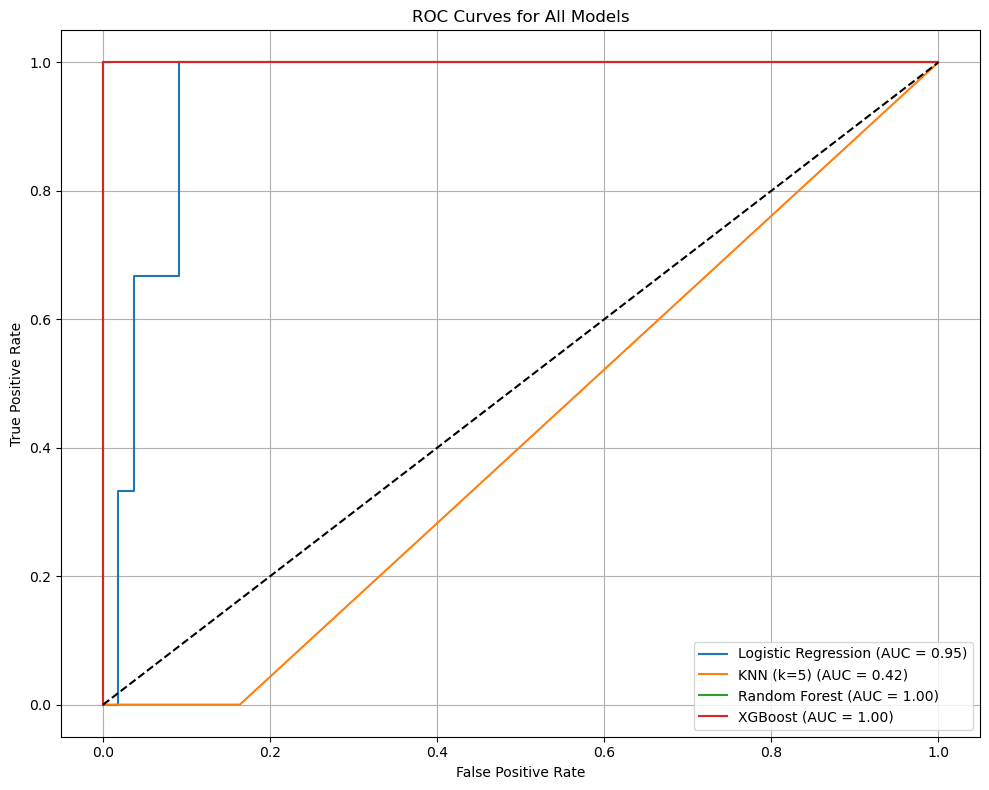

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.931034,0.4,0.666667,0.5,0.951515
1,KNN (k=5),0.948276,0.0,0.000000,0.0,0.418182
2,Random Forest,0.965517,1.0,0.333333,0.5,1.000000
3,XGBoost,0.982759,1.0,0.666667,0.8,1.000000


In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve)

# 70% Train, 15% Validation, 15% Test — stratified
X = processed_df.drop(columns=["Is Legendary"])
y = processed_df["Is Legendary"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

# Store metrics
results = []

# Plot setup
plt.figure(figsize=(10, 8))

# Train & evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

# ROC curve details
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display comparison
results_df = pd.DataFrame(results)
display(results_df)

In [99]:
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index([], dtype='object')


In [100]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

<Figure size 1000x800 with 0 Axes>

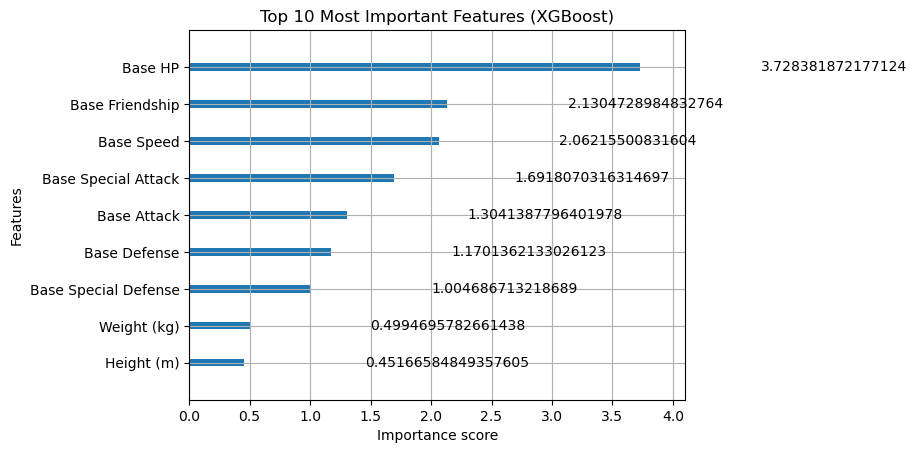

In [101]:
from xgboost import plot_importance
# create the feature plot for xgboost
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='gain')  # 'gain' is most insightful
plt.title("Top 10 Most Important Features (XGBoost)")
plt.show()

In [102]:
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                Feature  Importance
0               Base HP    3.728382
8       Base Friendship    2.130473
5            Base Speed    2.062155
3   Base Special Attack    1.691807
1           Base Attack    1.304139
2          Base Defense    1.170136
4  Base Special Defense    1.004687
7           Weight (kg)    0.499470
6            Height (m)    0.451666
